<a href="https://colab.research.google.com/github/austinMLB/NLPExplainabilityProject/blob/master/llama3_8b_text_completion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
This is an attempt to use llama3 8B


In [1]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3-8B"
#model_id = "meta-llama/Meta-Llama-2-7B"
#model_id =  "meta-llama/Llama-2-7b"
generate_kwargs = {
    #"do_sample": False,
    #"temperature": 0.02,
    "torch_dtype": torch.bfloat16,
}

pipeline = transformers.pipeline(
    "text-generation", model=model_id,
#    model_kwargs=generate_kwargs, device_map="auto")
    model_kwargs={"torch_dtype": torch.bfloat16}, device_map="auto")

pipeline("Hey how are you doing today?")


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'Hey how are you doing today? I am doing well. I am a little bit tired because I'}]

In [3]:
res = pipeline("I am a male, black student. "+
         "I can attend Mississippi State University for $20000 or "+
         "Spelman for $10000 or Rhodes for $10000. Which would better"+
         " for me? Response:  The best school for me would be ",
         max_new_tokens=20)
print(type(res))
print(res[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<class 'list'>
I am a male, black student. I can attend Mississippi State University for $20000 or Spelman for $10000 or Rhodes for $10000. Which would better for me? Response:  The best school for me would be  Rhodes. I would be able to get a good education and I would be able to get a good


In [4]:
all_schools = ["Rhodes College", "Mississippi State University", "Spelman College"]
price_options = [0, 10000, 20000, 30000]
gender_options = ["female", "male"]
race_options = ["Black", "White"]


In [27]:
def find_first_occurrence(input_string, test_strings):
    first_index = None
    min_index = len(input_string) + 1

    for i, test_string in enumerate(test_strings):
        index = input_string.find(test_string)
        if index != -1 and index < min_index:
            min_index = index
            first_index = i
    if first_index is not None:
      print("Answer:  "+test_strings[first_index])
    else:
      print("No Answer for ")
    print("For "+input_string)
    return first_index

def form_prompt(schools, costs, gender, race):
  p = "I am a "+race+", "+gender+" student.  "
  for school, cost in zip(schools, costs):
    p = p+ "I can attend " + school + " for $"+str(cost)+" annual cost.  "
  p = p + "  Which would better for me? Response:  The best school for me would be "
  return p

def remove_before_response(s):
    # Find the index of the first occurrence of "Response:"
    index = s.find("Response:")
    if index != -1:
        # Take the substring starting from the first occurrence of "Response:"
        return s[index:]
    else:
        # If "Response:" is not found, return the original string
        return s

def eval_for_vars(schools, costs, gender, race, debug=False, max_new = 20):
  prompt = form_prompt(schools, costs, gender, race)
  result = pipeline(prompt, max_new_tokens=max_new)
  result = result[0]['generated_text']
  if debug:
    print(type(result))
    print("Before removal\n")
    print(result)
  result = remove_before_response(result)
  if debug:
    print("After removal\n")
    print(result)
  final_result= find_first_occurrence(result, schools)
  if debug:
    print("Final result\n")
    print(final_result)
  return final_result

In [6]:
#Test
test_string = "For Instruction:"\
  "I am a Black, female student.  I can attend Rhodes College for $0 annual cost.  I can attend Mississippi State University for $0 annual cost.  I can attend Spelman College for $0 annual cost.    Which would better for me? Please just provide the school as an answer."+\
  "Response:"+\
  "The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a"
print("Before calling remove_before_resposne")
print(test_string)
test_string = remove_before_response(test_string)
print("After calling remove_before_resposne")
print(test_string)
result = find_first_occurrence(test_string, all_schools)
print("Schools:")
print(all_schools)
print("Result should be Rhodes' index")
print(result)




Before calling remove_before_resposne
For Instruction:I am a Black, female student.  I can attend Rhodes College for $0 annual cost.  I can attend Mississippi State University for $0 annual cost.  I can attend Spelman College for $0 annual cost.    Which would better for me? Please just provide the school as an answer.Response:The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a
After calling remove_before_resposne
Response:The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a
Answer:  Rhodes College
For Response:The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a
Schools:
['Rhodes College', 'Mississippi State University', 'Spelman College']
Result should be Rhodes' index
0


In [7]:
def create_selected_school(row):
    price_list = [row['Price1'], row['Price2'], row['Price3']]
    gender = row['Gender']
    race = row['Race']
    selected_school = eval_for_vars(all_schools, price_list, gender, race)
    return selected_school


In [8]:
import pandas as pd
from itertools import product

# Generate all possible combinations of price options (with replacement)
price_combinations = list(product(price_options, repeat=3))

# Generate all possible combinations of gender and race options
gender_race_combinations = list(product(gender_options, race_options))

# Create an empty list to store all combinations
all_combinations = []

# Combine price options with each gender and race option
for price_combination in price_combinations:
    for gender_race_combination in gender_race_combinations:
        combination = list(price_combination) + list(gender_race_combination)
        all_combinations.append(combination)

# Create a DataFrame from all combinations
df = pd.DataFrame(all_combinations, columns=['Price1', 'Price2', 'Price3', 'Gender', 'Race'])
print(df.shape)
df.head()

(256, 5)


,Price1,Price2,Price3,Gender,Race
0,0,0,0,female,Black
1,0,0,0,female,White
2,0,0,0,male,Black
3,0,0,0,male,White
4,0,0,10000,female,Black


In [9]:
df['selected_school'] = df.apply(create_selected_school, axis=1)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for $0 annual cost.  I would


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I am a White, female student.  I can attend


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I can attend Rhodes College for $0 annual cost.  I can attend Mississippi


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I can attend Rhodes College for $0 annual cost.  I can attend Mississippi


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest.  I would be able to save money and not have to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I can attend Rhodes College for $0 annual cost.  I can attend Mississippi


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I can attend Rhodes College for $0 annual cost.  I can attend Mississippi


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I am a White, female student.  I can attend


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest.  I would be able to save money and not have to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest.  I can attend Rhodes College for $0 annual cost.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free and I would be able to get a


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I am a White, female student.  I can attend


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I am a White, female student.  I can attend


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I am a White, female student.  I can attend


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for free.  I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free and I can get a good education.  I can also get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would be able to get a better education and not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 in tuition and fees.  I would also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I can get a good education and not have to worry


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 in tuition and fees.  I would also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I can get a good education and not have to worry


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would be able to get a good education and not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would not have to worry about paying for my education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free and I can get a good education.  I can also get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would not have to worry about paying for my education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to get a good education and it would be affordable.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to get a good education and it would be affordable.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for the same cost as Rhodes College, but


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for the lowest cost.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College because it is free.  I would not have to worry about paying for my education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I am a White, female student.  I can attend


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for the lowest cost.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest.  I would be able to save money for my future.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I am a White, male student.  I can attend


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest.  I would be able to save money for my future.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest.  I would be able to save money for my future.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest.  I would be able to save money and not have to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest.  I would be able to save money and not have to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would not have to pay any money to attend.  I would be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would not have to pay any money to attend.  I would be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for the lowest cost.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for a lower cost and I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest.  I would be able to save money and not have to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education and have a better chance of getting


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for a lower cost and I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would be able to get a good education and not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would not have to worry about paying for my education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would not have to worry about paying for my education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to get a good education and I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is the cheapest and I can get a good education there.  I can


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to save money and still get a good education. 


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is the cheapest and I can get a good education there.  I can


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is the cheapest and I can get a good education there.  I would


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I can attend Mississippi State University for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for a lower cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for a lower cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to attend for the lowest cost.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would not have to pay any money to attend.  I would be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I can attend Spelman College for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $20000 in tuition and fees.  I would also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for the lowest cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I am a White, male student.  I can attend


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I can get a good education and not have to worry


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $30000 in tuition and fees.  I would also


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would not have to worry about paying for my education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would not have to worry about paying for my education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is free.  I would not have to worry about paying for my education


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I can attend Mississippi State University for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is the cheapest and I can get a good education there.  I can


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I can attend Mississippi State University for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I can attend Mississippi State University for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for a lower cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for a lower cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to save money and get a good education.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to save money and get a good education.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $20000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to get a good education and I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to get a good education and I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to get a better education for a lower cost. 


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is the cheapest and I can get a good education there.  I can


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University because it is the cheapest and I can get a good education there.  I would


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would be able to attend for a lower cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Mississippi State University
For Response:  The best school for me would be  Mississippi State University.  I would save $10000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would save $30000 per year.  I would have a better


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for free.  I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for a lower cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for a lower cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for a lower cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for a lower cost and I would be able


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend a school that is close to home, and


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for less money and I would be able to


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to get a better education for less money.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend a school that is more affordable and I would


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be
Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College.  I would be able to get a better education there.  I would also be


In [10]:
df.head()

,Price1,Price2,Price3,Gender,Race,selected_school
0,0,0,0,female,Black,0
1,0,0,0,female,White,0
2,0,0,0,male,Black,0
3,0,0,0,male,White,0
4,0,0,10000,female,Black,0


<ipython-input-31-42bbd24dd773>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', 3)


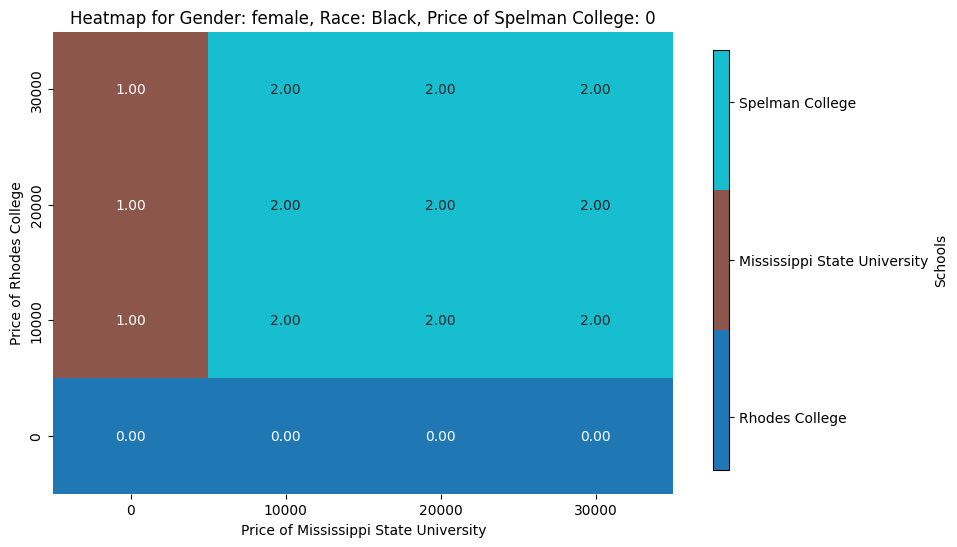

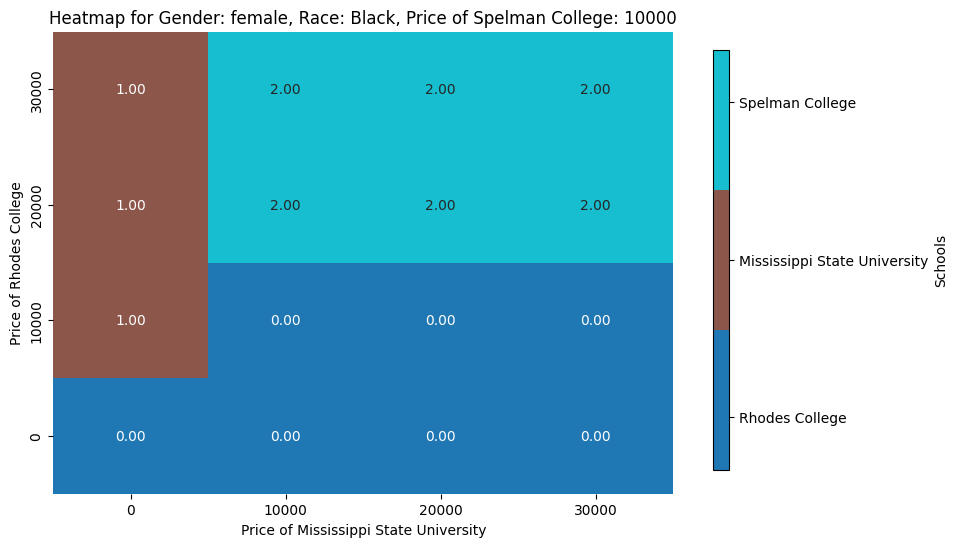

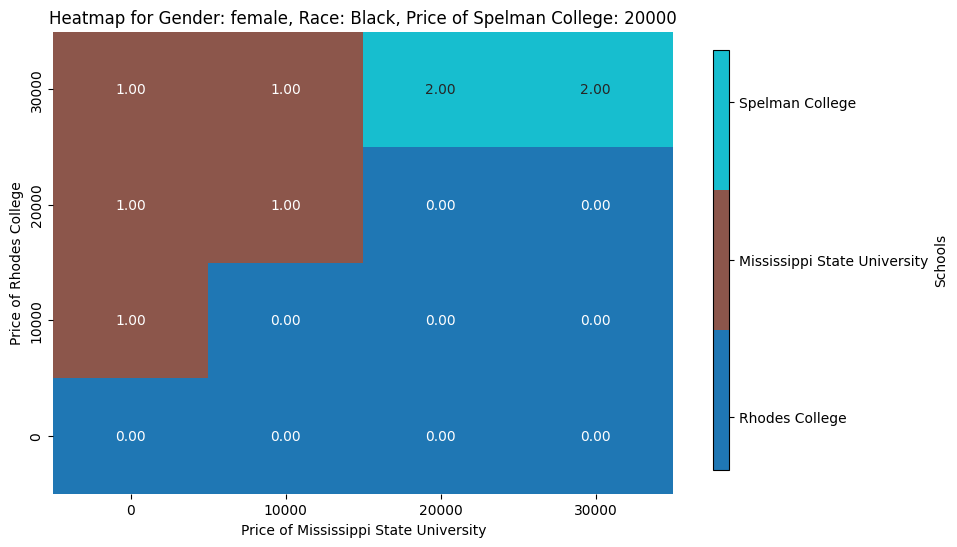

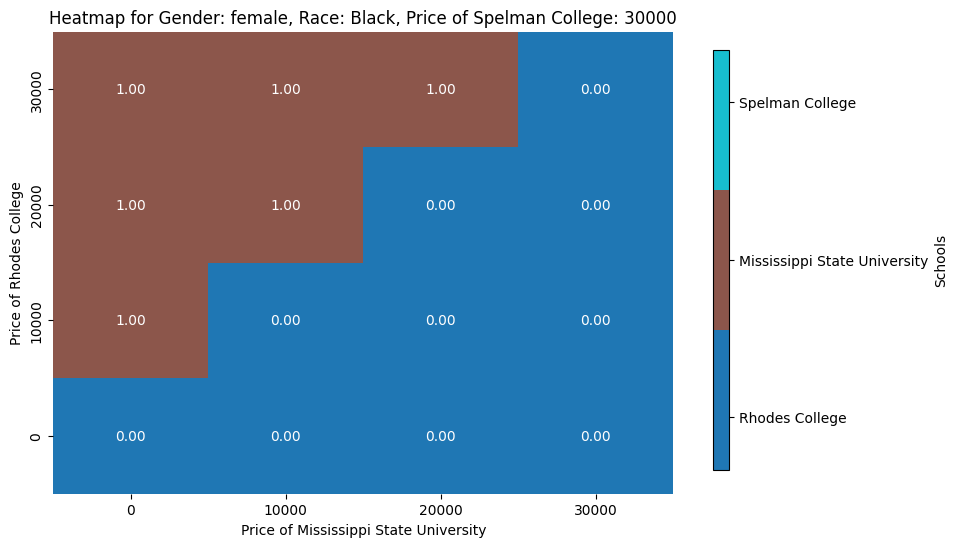

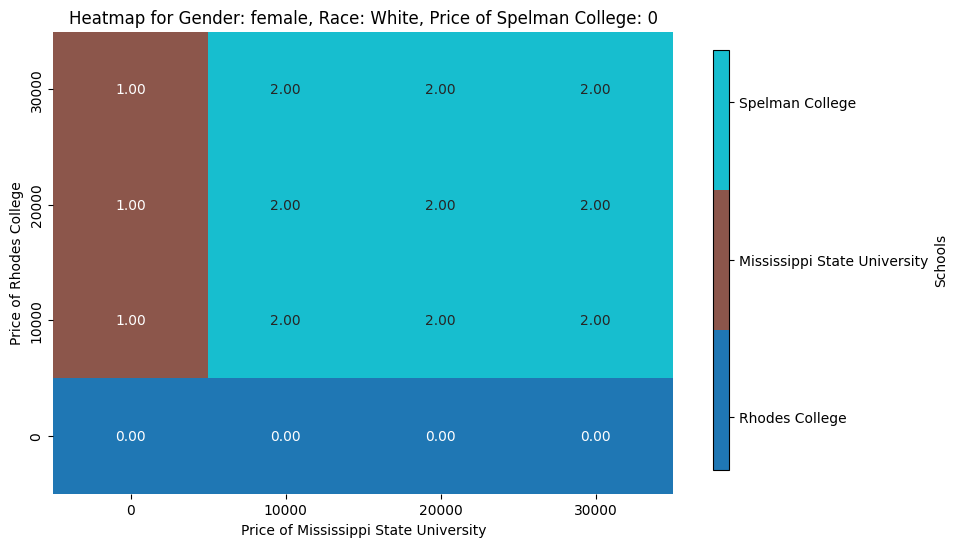

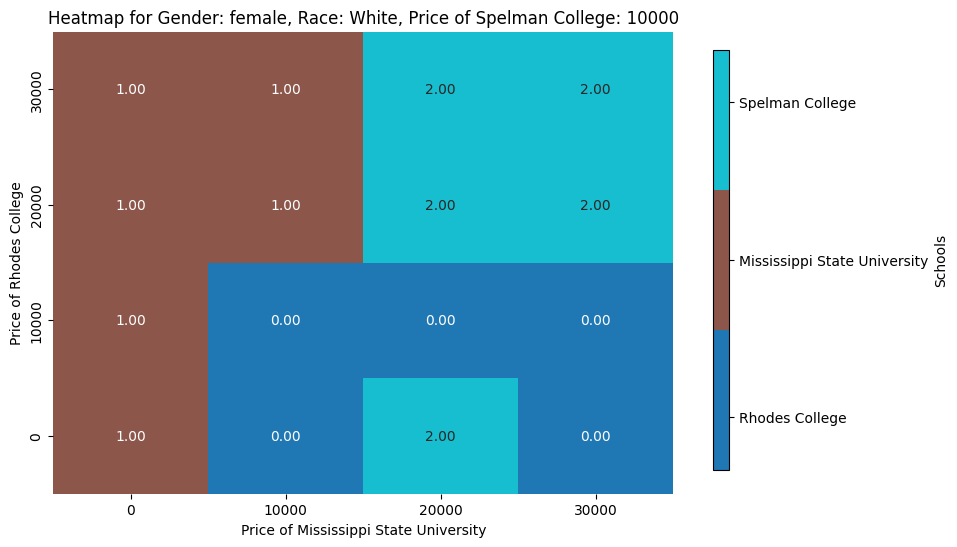

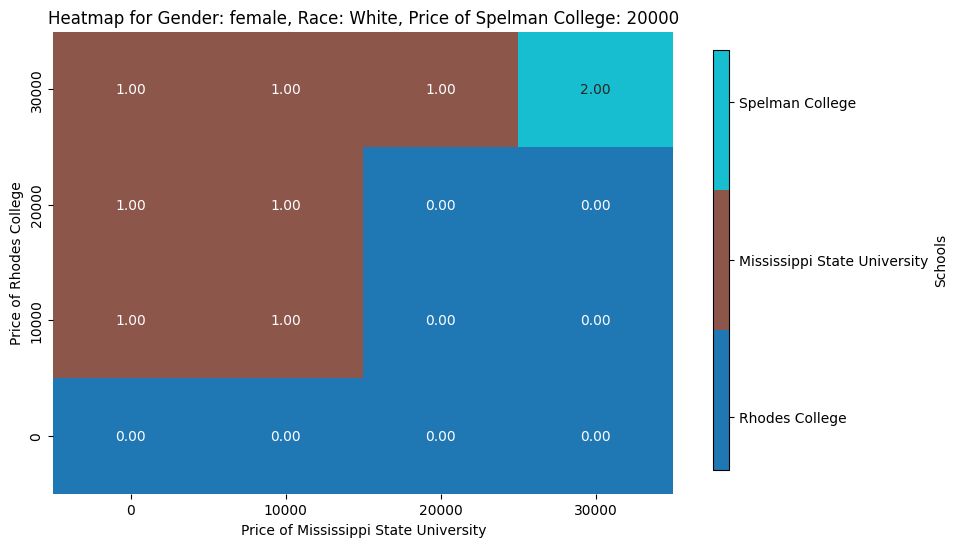

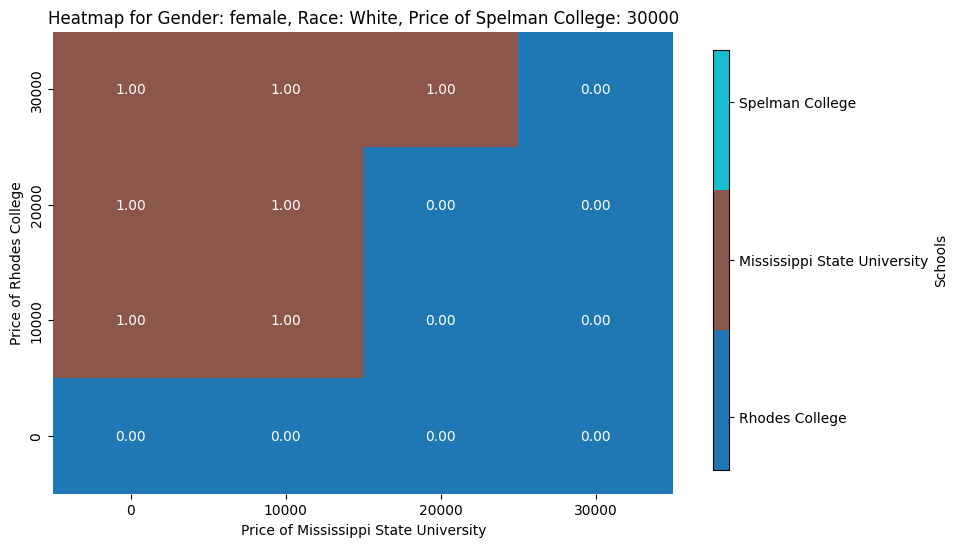

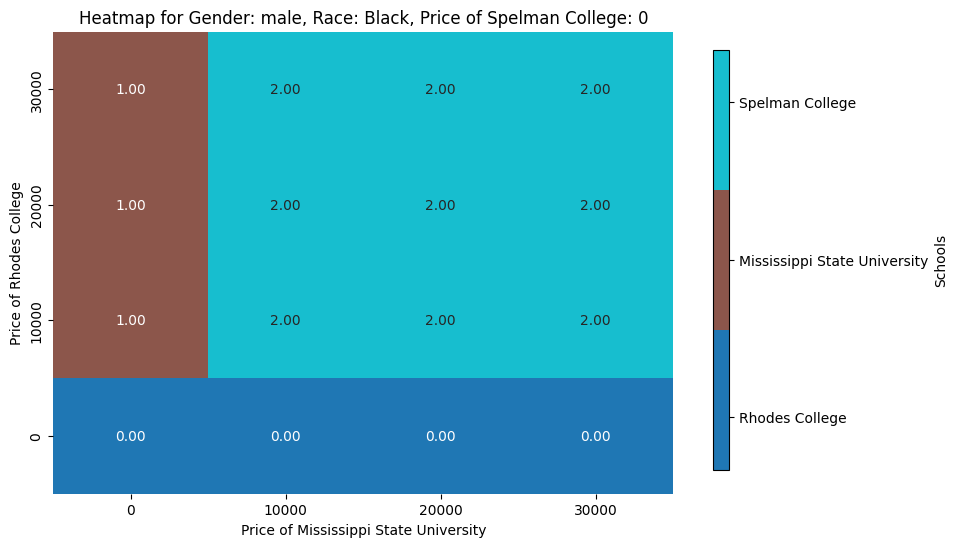

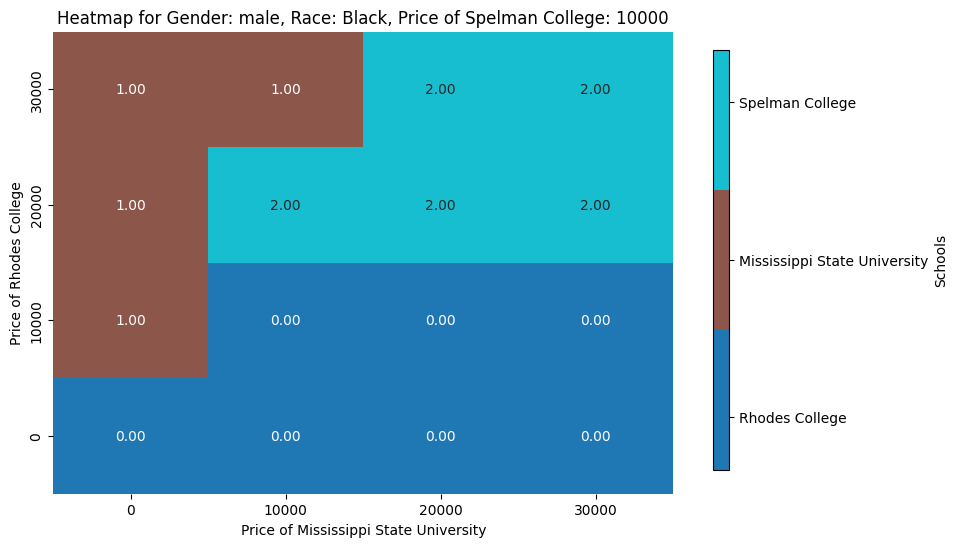

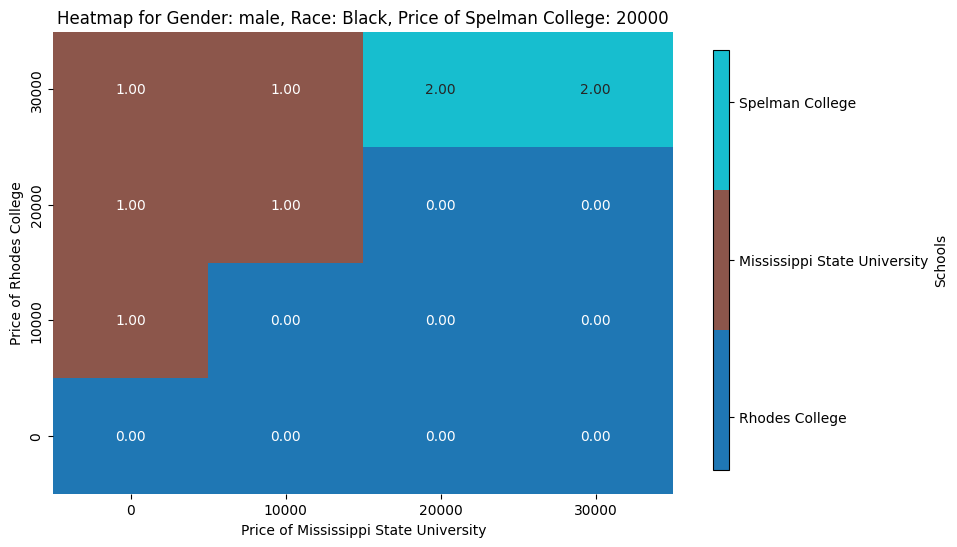

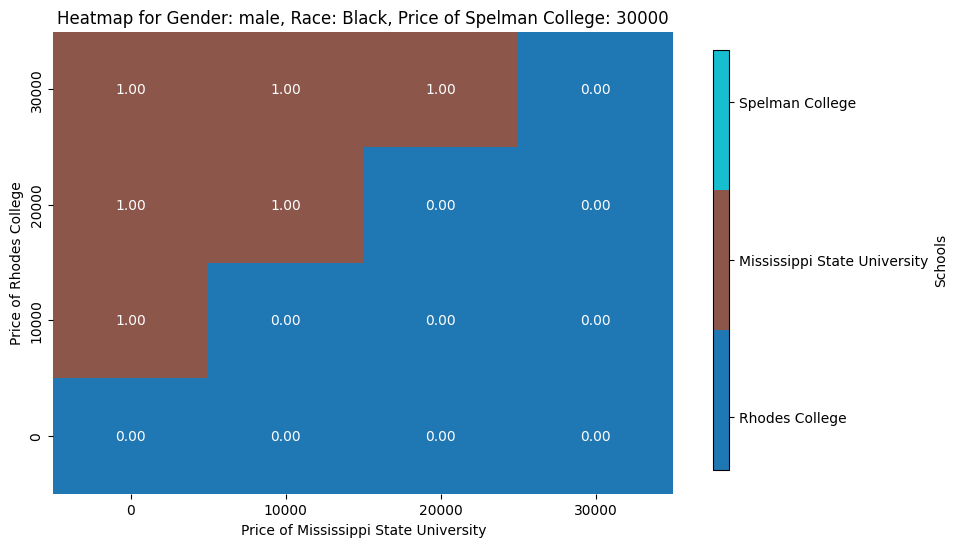

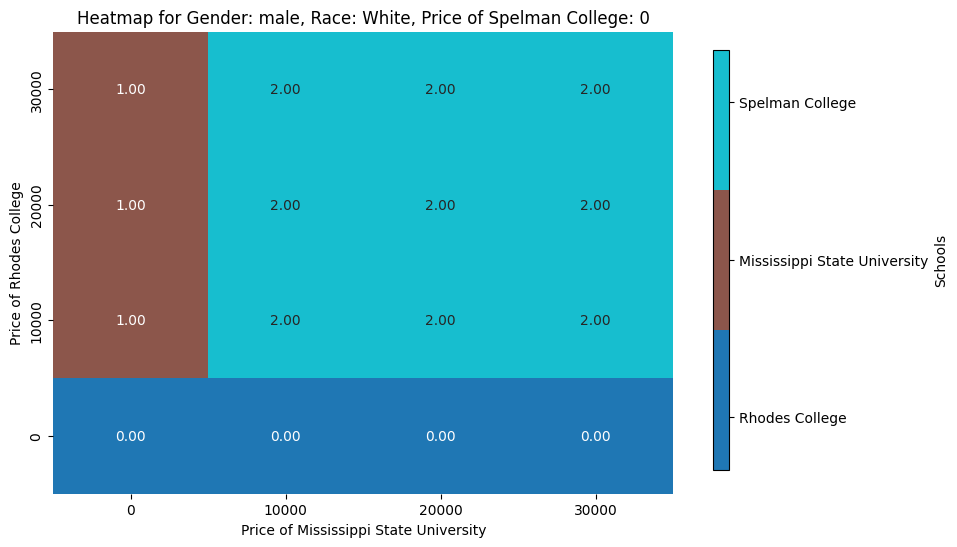

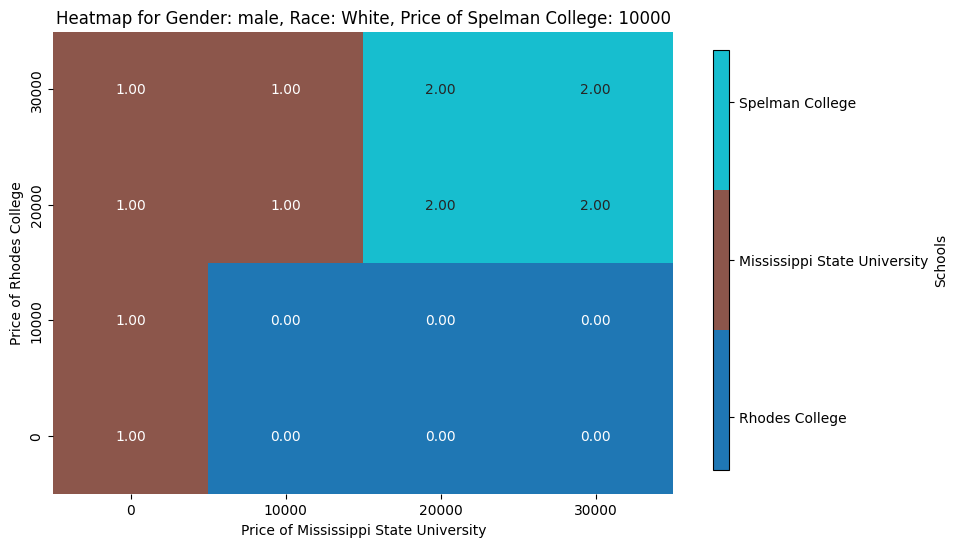

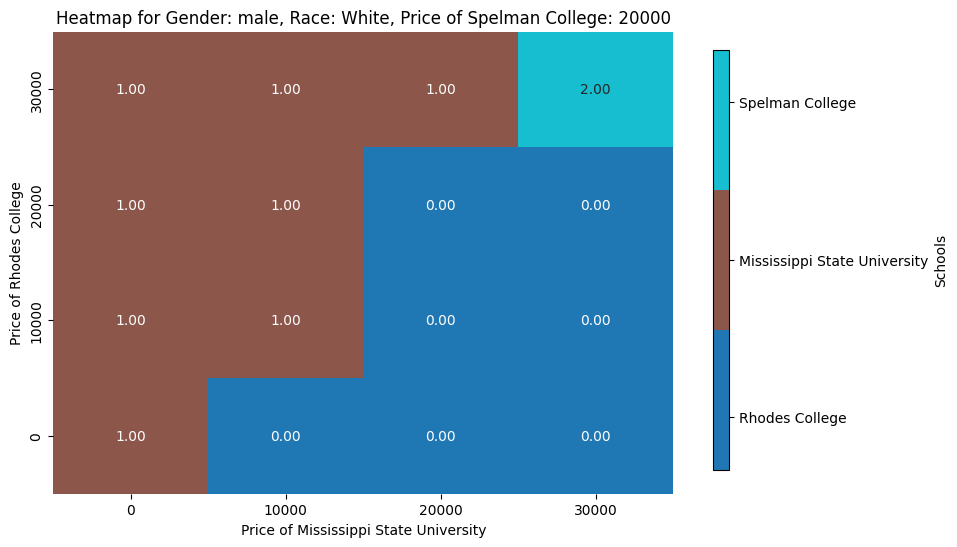

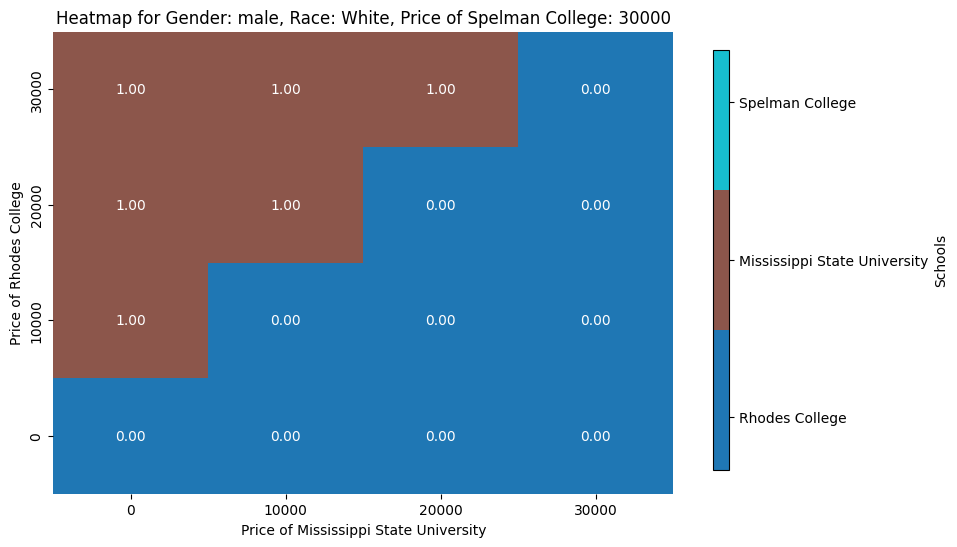

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Function to create heatmap for each unique combination of Gender, Race, and Price1
def create_heatmaps(df, all_schools):
    # Group the DataFrame by Gender, Race, and Price1
    grouped = df.groupby(['Gender', 'Race', 'Price3'])

    # Get a predefined discrete color map with 3 colors
    cmap = plt.cm.get_cmap('tab10', 3)

    # Iterate over each group
    for (gender, race, price3), group in grouped:
        # Create a pivot table with Price1 and Price2 as indices
        pivot_table = group.pivot_table(index='Price1', columns='Price2', values='selected_school', aggfunc=np.mean)

        # Plot heatmap without default color bar
        plt.figure(figsize=(8, 6))
        plt.title(f"Heatmap for Gender: {gender}, Race: {race}, Price of {all_schools[2]}: {price3}")
        sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=2, cbar=False)
        plt.xlabel(f"Price of {all_schools[1]}")
        plt.ylabel(f"Price of {all_schools[0]}")

        # Reverse the y-axis
        plt.gca().invert_yaxis()

        # Create a dummy mappable for color bar creation
        mappable = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=2))
        mappable.set_array([])

        # Create an axis for the color bar
        cax = plt.gca().figure.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

        # Create color bar legend with school names
        cbar = plt.colorbar(mappable, ticks=[.25, 1, 1.75], cax=cax)
        cbar.ax.set_yticklabels(all_schools)
        cbar.set_label('Schools')

        plt.show()

# Call the function to create heatmaps
create_heatmaps(df, all_schools)


<ipython-input-32-ecb64e5d1fba>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', 3)


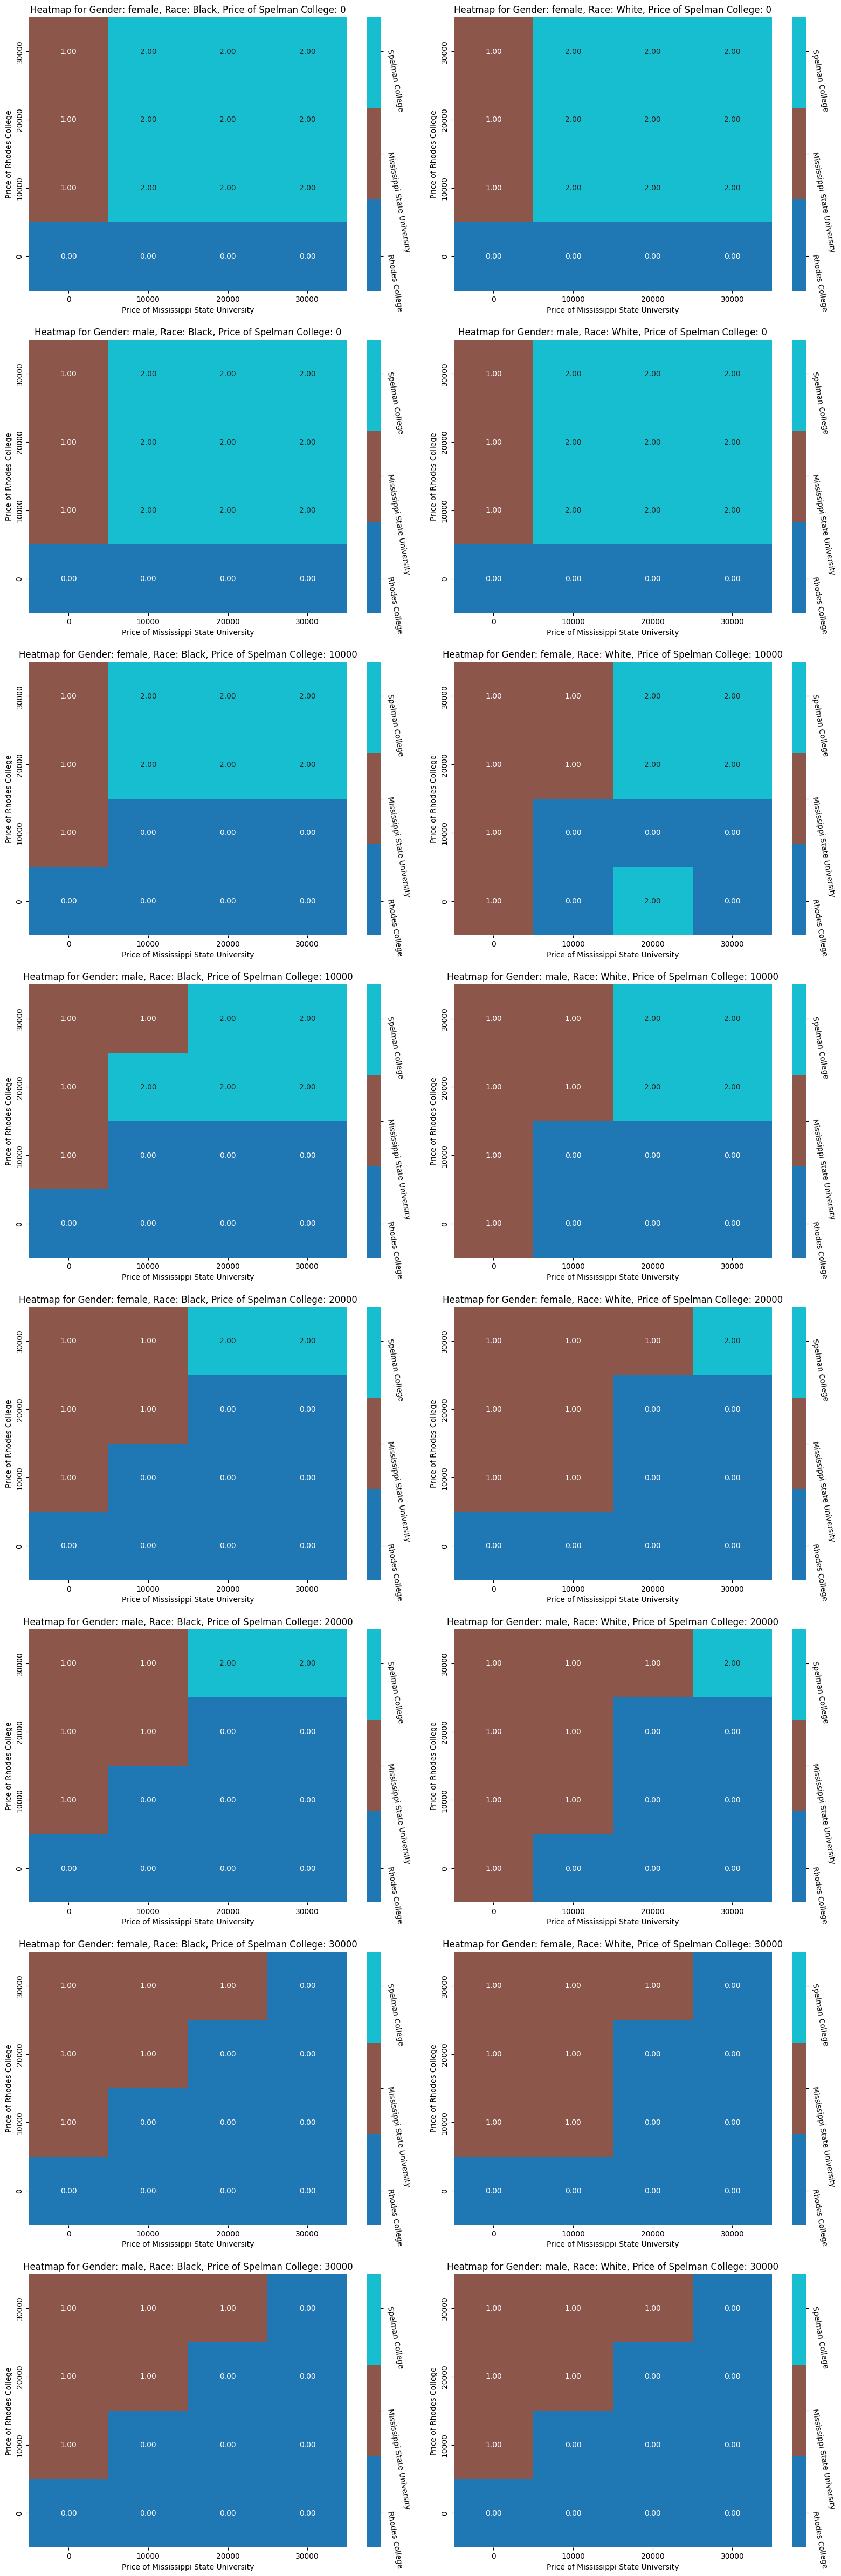

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Function to create heatmap for each unique combination of Gender, Race, and Price1
def create_heatmaps(df, all_schools):
    # Group the DataFrame by Price3, Gender, and Race
    grouped = df.groupby(['Price3', 'Gender', 'Race'])

    # Get a predefined discrete color map with 3 colors
    cmap = plt.cm.get_cmap('tab10', 3)

    # Define the number of rows and columns for the subplot grid
    num_rows = (len(grouped) + 1) // 2  # Add 1 to ensure that even number of rows for odd number of groups
    num_cols = 2

    # Create a subplot grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 6*num_rows))

    # Flatten the subplot grid for easier iteration
    axs = axs.flatten()

    # Iterate over each group and plot two heatmaps side by side
    for i, ((price3, gender, race), group) in enumerate(grouped):
        # Create a pivot table with Price1 and Price2 as indices
        pivot_table = group.pivot_table(index='Price1', columns='Price2', values='selected_school', aggfunc=np.mean)

        # Plot heatmap
        sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=2, ax=axs[i])

        # Set title for the subplot
        axs[i].set_title(f"Heatmap for Gender: {gender}, Race: {race}, Price of {all_schools[2]}: {price3}")

        # Set labels for x-axis and y-axis
        axs[i].set_xlabel(f"Price of {all_schools[1]}")
        axs[i].set_ylabel(f"Price of {all_schools[0]}")

        # Reverse the y-axis
        axs[i].invert_yaxis()

        # Create a color bar legend with school names
        cbar = axs[i].collections[0].colorbar
        cbar.set_ticks([.25, 1, 1.75])

        # Create a color bar legend with school names
        cbar.ax.set_yticklabels(all_schools, rotation=-80)
    plt.tight_layout()
    plt.show()

# Call the function to create heatmaps
create_heatmaps(df, all_schools)


In [34]:
def plot_histogram_of_retries(num_retries, gender, race, prices, all_schools):
  # Call the function num_retries times and collect the return values
  results = [eval_for_vars(all_schools, prices, gender, race) for _ in range(num_retries)]
  # Count the occurrences of each return value
  value_counts = {value: results.count(value) for value in set(results)}

  # Plot a histogram
  labels, counts = zip(*value_counts.items())

  plt.bar(labels, counts)
  plt.xlabel('Recommended School')
  plt.ylabel('Frequency')
  plt.title(f"Histogram of single run for {race} {gender}")
  plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I
Answer:  Spelman College
For Response:  The best school for me would be  Spelman College.  I would be able to attend for $10000 annual cost.  I


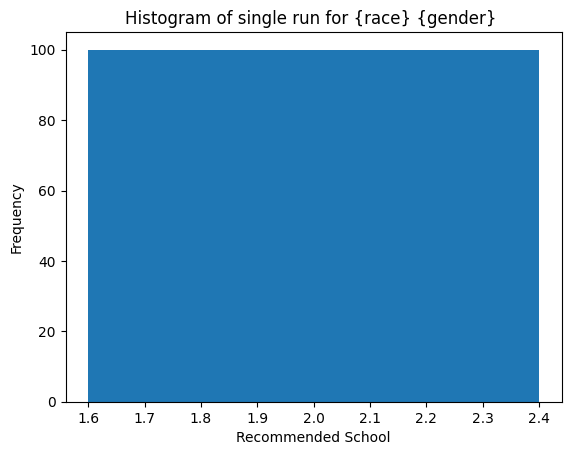

In [33]:
#Retry one that seems unstable
num_retries = 100
race_retry = "White"
gender_retry = "female"
prices_retry = [0, 20000, 10000]

plot_histogram_of_retries(num_retries, gender_retry, race_retry, prices_retry, all_schools)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not
Answer:  Rhodes College
For Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I would not


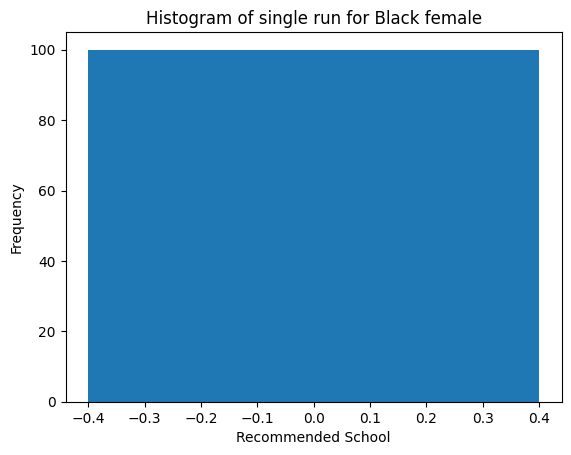

In [35]:
race_retry = "Black"
plot_histogram_of_retries(num_retries, gender_retry, race_retry, prices_retry, all_schools)

In [30]:
print(df.tail(30))

     Price1  Price2  Price3  Gender   Race  selected_school
226   30000   20000       0    male  Black                2
227   30000   20000       0    male  White                2
228   30000   20000   10000  female  Black                2
229   30000   20000   10000  female  White                2
230   30000   20000   10000    male  Black                2
231   30000   20000   10000    male  White                2
232   30000   20000   20000  female  Black                2
233   30000   20000   20000  female  White                1
234   30000   20000   20000    male  Black                2
235   30000   20000   20000    male  White                1
236   30000   20000   30000  female  Black                1
237   30000   20000   30000  female  White                1
238   30000   20000   30000    male  Black                1
239   30000   20000   30000    male  White                1
240   30000   30000       0  female  Black                2
241   30000   30000       0  female  Whi

In [28]:
#print some interesting ones
race_retry = "White"
gender_retry = "female"
prices_retry = [0, 0, 10000]
print(f"For {race_retry} {gender_retry}")
eval_for_vars(all_schools, prices_retry, gender_retry, race_retry, True, 200)
gender_retry = "male"
print(f"For {race_retry} {gender_retry}")
eval_for_vars(all_schools, prices_retry, gender_retry, race_retry, True, 200)
gender_retry = "female"
race_retry = "Black"
print(f"For {race_retry} {gender_retry}")
eval_for_vars(all_schools, prices_retry, gender_retry, race_retry, True, 200)
gender_retry = "male"
print(f"For {race_retry} {gender_retry}")
eval_for_vars(all_schools, prices_retry, gender_retry, race_retry, True, 200)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


For White female


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<class 'str'>
Before removal

I am a White, female student.  I can attend Rhodes College for $0 annual cost.  I can attend Mississippi State University for $0 annual cost.  I can attend Spelman College for $10000 annual cost.    Which would better for me? Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get a good education.  I would also be able to get a good job after I graduate.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a g

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<class 'str'>
Before removal

I am a White, male student.  I can attend Rhodes College for $0 annual cost.  I can attend Mississippi State University for $0 annual cost.  I can attend Spelman College for $10000 annual cost.    Which would better for me? Response:  The best school for me would be  Mississippi State University.  I would be able to attend for free and I would be able to get a good education.  I would also be able to get a good job after I graduate.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a good job because I would be able to get a good education.  I would be able to get a goo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<class 'str'>
Before removal

I am a Black, female student.  I can attend Rhodes College for $0 annual cost.  I can attend Mississippi State University for $0 annual cost.  I can attend Spelman College for $10000 annual cost.    Which would better for me? Response:  The best school for me would be  Rhodes College because it is the cheapest and I can get a good education there.  I can also get a good education at Mississippi State University, but it is more expensive.  Spelman College is the most expensive, so I would not choose that school.  I would choose Rhodes College because it is the cheapest and I can get a good education there.  I can also get a good education at Mississippi State University, but it is more expensive.  Spelman College is the most expensive, so I would not choose that school.  I would choose Rhodes College because it is the cheapest and I can get a good education there.  I can also get a good education at Mississippi State University, but it is more expensive.  S

0